In [1]:
# Useful starting lines
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [35]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
df = pd.DataFrame(np.c_[tX,y])
df = pd.DataFrame(np.c_[tX,y]).replace(-999., pd.NA).fillna(df.median())

df_pri = df[df.columns.drop(list(df.filter(regex="DER")))]
df_der = df[df.columns.drop(list(df.filter(regex="PRI")))]



df_np=df.to_numpy(dtype="float128")
df_der_np=df_der.to_numpy(dtype="float128")
df_pri_np=df_pri.to_numpy(dtype="float128")

y=df_np[:,30]
tX=df_np[:,0:30]

y_der=df_der_np[:,30]
tX_der=df_der_np[:,0:30]

y_pri=df_pri_np[:,30]
tX_pri=df_pri_np[:,0:30]


In [31]:
(np.count_nonzero(tX == -999, axis=0) / len(tX))

array([0.      , 0.      , 0.      , 0.      , 0.709828, 0.709828,
       0.709828, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.709828, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.709828, 0.709828, 0.709828, 0.      ])

We went from 250000 rows to 68114...

In [3]:
def standardize_data(tx):
    return np.c_[np.ones(tx.shape[0]),(tx-np.mean(tx, axis=0))/np.std(tx,axis=0)]

In [5]:
tX_std=standardize_data(tX)
print(tX_std)

[[ 1.          0.36122749  0.06833197 ...  1.5668      1.55858439
   0.4125105 ]
 [ 1.          0.7843647   0.55250482 ... -0.63936657 -0.63936694
  -0.27381996]
 [ 1.         -0.26891115  3.19515553 ... -0.63936657 -0.63936694
  -0.29396985]
 ...
 [ 1.         -0.26053014  0.31931645 ... -0.63936657 -0.63936694
  -0.31701723]
 [ 1.         -0.45839721 -0.84532397 ... -0.63936657 -0.63936694
  -0.74543941]
 [ 1.         -0.26891115  0.66533608 ... -0.63936657 -0.63936694
  -0.74543941]]


In [6]:
def compute_loss(y,tx,w):
    tmp = y-tx@w
    return tmp.T@tmp/(2*len(y))

In [7]:
def least_squares(y, tx):
    #WX=Y =>W=YX-1
    w = np.linalg.inv(tx.T@tx)@tx.T@y
    loss = compute_loss(y,tx,w)
    return (w,loss)
    

In [8]:
def logistic_regression_GD(y, tx, w, n_max_iters=50, gamma=0.1,lambda_ =15000, alpha=0.5, lr_decay=0, plot_accuracy=False):


    lr = gamma
    loss = 0
    accuracy=[]
    for i in range(n_max_iters):
        #loss += elastic_net_loss(y,tx,w,lambda_, 0.3) 
        if plot_accuracy:
            accuracy.append(np.sum(predict_labels(w, tx) == y)/len(y)*100)

        if i%(n_max_iters//10)==0:
            print("Iteration {}/ {}".format(i,n_max_iters))
            print("Accuracy = {}%".format(np.sum(predict_labels(w, tx) == y)/len(y)*100))
        
        w-=lr *elastic_net_grad(y,tx,w,lambda_, alpha)
        gamma *= (1. / (1. + lr_decay*i))

    print("Iteration {}/ {}".format(i+1,n_max_iters))
    print("Accuracy = {}%".format(np.sum(predict_labels(w, tx) == y)/len(y)*100))
        
    if plot_accuracy:
        plt.plot(range(0,len(accuracy)),accuracy)
    
    return (w,loss)

In [9]:
def logistic_regression_SGD(y, tx, w, n_max_iters=1000, batch_size=30,gamma=0.1,lambda_ =15000, alpha=0.5, lr_decay=0, plot_accuracy=False, logs=True):

    lr = gamma
    loss = 0
    accuracy=[]
    max_accuracy=0
    best_epoch=-1
    
    for i in range(n_max_iters):
        #loss += elastic_net_loss(y,tx,w,lambda_, 0.3) 
        mask = np.random.choice(tx.shape[0], batch_size, replace=False)
        tx_sample= tx[mask]
        y_sample=y[mask]
        if plot_accuracy:
            accuracy.append(np.sum(predict_labels(w, tx) == y)/len(y)*100)
            if accuracy[i]>max_accuracy:
                max_accuracy=accuracy[i]
                best_epoch=i

        if logs and i%(n_max_iters//10)==0:
            print("Iteration {}/ {}".format(i,n_max_iters))
            print("Accuracy = {}%".format(np.sum(predict_labels(w, tx) == y)/len(y)*100))
        
        w-=lr *elastic_net_grad(y_sample,tx_sample,w,lambda_, alpha)
        gamma *= (1. / (1. + lr_decay*i))

    if logs:
        print("Iteration {}/ {}".format(i+1,n_max_iters))
        print("Accuracy = {}%".format(np.sum(predict_labels(w, tx) == y)/len(y)*100))
        
    if plot_accuracy:
        plt.plot(range(0,len(accuracy)),accuracy)
        print("Best Accuracy : {}% reached at epoch {}".format(max_accuracy, best_epoch))
    
    return (w,loss)

In [10]:
def elastic_net_loss(y, tx, w, lambda_, alpha):
    #TODO fix
    squared_diff = ((y-w@tx.T)**2)/2
    loss = squared_diff.mean()+lambda_*(1-alpha)/2*np.sum(w**2)+lambda_*alpha*np.sum(np.aps(w))
    return loss

In [11]:
def ridge_reg_loss(y,tx,w, lambda_):
    return elastic_net_loss(y,tx, w, lambda_, 0)

In [12]:
def lasso_reg_loss(y,tx,w, lambda_):
    return elastic_net_loss(y,tx, w, lambda_, 1)

In [13]:
def elastic_net_grad(y,tx,w,lambda_, alpha):
    return tx.T@(sigmoid(tx@w)-y) + (1-alpha)*lambda_*w + alpha*lambda_*np.sign(w)

In [14]:
def sigmoid(x):
    x=np.clip(x,-20,20)
    return np.exp(x)/(1+np.exp(x))

In [15]:
def train(y,tx, method, **kwargs):
    y = y.reshape(-1,1)
    w =np.random.rand(tx.shape[1],1)
    #print("y shape : {}\nx shape : {}\nw shape : {}".format(y.shape, tX.shape, w.shape))

    return method(y,tx, w, **kwargs)    

In [27]:
def k_fold_CV(y,tx, method=logistic_regression_SGD, k=10, **kwargs):

    accuracy=[]
    max_accuracy=0
    y = y.reshape(-1,1)
    index_list=np.array(range(tx.shape[0]))
    np.random.shuffle(index_list)
    masks=np.array(np.array_split(index_list,k))


    for i in range(k):
        #print("Batch shape for tx {}".format(tx[np.delete(masks,i,0).flatten()].shape))

        w,loss = train(y[np.delete(masks,i,0).ravel()],tx[np.delete(masks,i,0).ravel()],method, **kwargs)
        accuracy.append(np.sum(predict_labels(w, tx)[:,0] == y[:,0])/len(y)*100)
        if max_accuracy<accuracy[i]:
            max_accuracy=accuracy[i]
    plt.plot(range(len(accuracy)),accuracy)
    print("Max accuracy this run was {}%".format(max_accuracy))
    return np.mean(accuracy)

In [17]:
def simple_polynomial_feature_expansion(tx, degree=2):
    tx_dlc = np.empty((tx.shape[0],0))
    if degree<2:
        return tx_dlc
    for i in range(tx.shape[1]):
        
        for d in range(2,degree+1):
            tx_dlc=np.c_[tx_dlc, np.power(tx[:,i],d)]
    print("Polynomial expansion of degree {} done : adding {}".format(degree,tx_dlc.shape))

    return tx_dlc

In [18]:
def simple_logarithmic_feature_expansion(tx, degree=1):
    tx_pos = tx - tx.min(axis=0)
    tx_dlc = np.empty((tx.shape[0],0))
    if degree<1:
        return tx_dlc

    for i in range(tx.shape[1]):
        for d in range(1,degree+1):
            tx_dlc=np.c_[tx_dlc, np.power(np.log(1+tx_pos[:,i]),d)]
    print("Logarithmic expansion of degree {} done : adding {}".format(degree,tx_dlc.shape))

    return tx_dlc

In [19]:
def simple_root_feature_expansion(tx,degree=2):
    tx_pos = tx - tx.min(axis=0)
    tx_dlc = np.empty((tx.shape[0],0))
    if degree<2:
        return tx_dlc
    for i in range(tx.shape[1]):
            for d in range(2,degree+1):
                tx_dlc=np.c_[tx_dlc, np.power(tx_pos[:,i],1/d)]

    print("Root expansion of degree {} done : adding {}".format(degree,tx_dlc.shape))
    return tx_dlc

In [20]:
def simple_tan_hyp_feature_expansion(tx, degree=1):
    tx_tanh =np.tanh(tx)
    tx_dlc = np.empty((tx.shape[0],0))
    if degree<1:
        return tx_dlc
    for i in range(tx.shape[1]):
            for d in range(1,degree+1):
                tx_dlc=np.c_[tx_dlc, standardize(np.power(tx_tanh[:,i],d))]
                
    print("Hyperbolic tan expansion of degree {} done : adding {}".format(degree,tx_dlc.shape))
    return tx_dlc


In [21]:
def augment(tx, polynomial_degree=2, root_degree=2, log_degree=1, tan_hyp_deg=0):

    tx_aug = np.c_[tx,simple_polynomial_feature_expansion(tx,polynomial_degree)]

    tx_aug = np.c_[tx_aug,simple_logarithmic_feature_expansion(tx,log_degree)]

    tx_aug = np.c_[tx_aug,simple_root_feature_expansion(tx,root_degree)]

    tx_aug = np.c_[tx_aug,simple_tan_hyp_feature_expansion(tx,tan_hyp_deg)]


    tx_aug_std=standardize_data(tx_aug) 
    return tx_aug_std

In [22]:
def plot_grid_search(cv_results, lambdas, alphas, degrees):
    accu = np.array(cv_results["best_accuracy"]).reshape((len(alphas),len(lambdas), len(degrees)))
    _, ax = plt.subplots(1,1)
    for idx, val in enumerate(alphas):
            if np.mean(accu[idx,:])>0.70:
                ax.plot(lambdas, np.mean(accu[idx,:],axis=1), '-o', label= alphas)

    ax.set_title("Grid Search Scores", fontsize=12, fontweight='bold')
   # ax.set_ylabel('CV Max Score', fontsize=16)
    ax.legend(loc="best", fontsize=6)
    ax.grid('on') 

In [27]:
plot_grid_search(cv_results, lambdas, alphas,degrees)

ValueError: cannot reshape array of size 559 into shape (14,10,3)

In [ ]:
def grid_search(y,tx, method=logistic_regression_SGD, k=5, n_max_iters=350, degrees=[3,2,1] ,gammas= np.logspace(-1,0,3), alphas=np.linspace(0,1,5), lambdas=np.logspace(-6,-3,10),lr_decay=0.08):
    max_accuracy=0
    i =0
    li=[*range(0,11)]
    cv_results={"lambda":[],"alpha":[],"degree":[], "best_accuracy":[]}

    for degree in degrees:
        tx_aug = np.c_[tx,simple_polynomial_feature_expansion(tX,degree)]
        tx_aug = np.c_[tx_aug,simple_logarithmic_feature_expansion(tX,degree)]
        tx_aug = np.c_[tx_aug,simple_root_feature_expansion(tX,degree)]
        tx_aug_std=standardize_data(tx_aug)
        for gamma in gammas:
            for lambda_ in lambdas:
                if len(li) and i/(len(lambdas)*len(alphas)*len(degrees)*len(gammas))*100>li[0]*10:
                    print("{}% completed".format(li.pop(0)*10))
                for alpha in alphas:
                    accu=k_fold_CV(y,tx_aug_std, method=method, k=k, n_max_iters=n_max_iters, gamma=gamma, lambda_=lambda_, alpha=alpha,lr_decay=lr_decay, logs=False, plot_accuracy=False)
                    if accu>0.72:
                        cv_results["lambda"].append(lambda_) 
                        cv_results["alpha"].append(alpha) 
                        cv_results["degree"].append(degree) 
                        cv_results["best_accuracy"].append(accu) 

                    if accu>max_accuracy:
                        best_gamma = gamma
                        max_accuracy=accu
                        best_lambda=lambda_
                        best_alpha=alpha
                        best_degree=degree
                    i+=1
    print("Max accuracy this run was {}% for gamma={}, lambda={}, alpha={} and degree={}".format(max_accuracy,best_gamma,best_lambda,best_alpha,best_degree))
    return cv_results


In [28]:
lambdas = np.logspace(-6,-3,15)
alphas = np.linspace(0,1,5)
degrees = [3,2]
gammas = np.logspace(-1,0,3)
grid_search(y,tX,lambdas=lambdas, alphas=alphas,degrees=degrees,gammas=gammas)

Polynomial expansion of degree 3 done : adding (250000, 60)
Logarithmic expansion of degree 3 done : adding (250000, 90)
Root expansion of degree 3 done : adding (250000, 60)


/tmp/ipykernel_6791/3860593830.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks=np.array(np.array_split(index_list,k))


IndexError: arrays used as indices must be of integer (or boolean) type

### Not standardized dataset

In [54]:
print("Max accuracy this run was {}% for gamma={}, lambda={}, alpha={} and degree={}".format(max_accuracy,best_gamma,best_lambda,best_alpha,best_degree ))
accu=k_fold_CV(y,tX_aug_std, logistic_regression_SGD, k=5, n_max_iters=350, gamma=best_gamma, lambda_=best_lambda, alpha=best_alpha,lr_decay=0.08, logs=False, plot_accuracy=True)


Max accuracy this run was 0% for gamma=0.1, lambda=0.0003727593720314938, alpha=0.75 and degree=3


TypeError: reg_logistic_regression_SGD() got an unexpected keyword argument 'degree'

Polynomial expansion of degree 2 done : adding (250000, 30)
Logarithmic expansion of degree 1 done : adding (250000, 30)
Root expansion of degree 2 done : adding (250000, 30)
Iteration 0/ 400
Accuracy = 59.6916%
Iteration 40/ 400
Accuracy = 74.4092%
Iteration 80/ 400
Accuracy = 74.8856%
Iteration 120/ 400
Accuracy = 73.9408%
Iteration 160/ 400
Accuracy = 74.1216%
Iteration 200/ 400
Accuracy = 74.6296%
Iteration 240/ 400
Accuracy = 74.6476%
Iteration 280/ 400
Accuracy = 74.3964%
Iteration 320/ 400
Accuracy = 74.66040000000001%
Iteration 360/ 400
Accuracy = 74.77000000000001%
Iteration 400/ 400
Accuracy = 74.2448%
Best Accuracy : 75.1104% reached at epoch 24


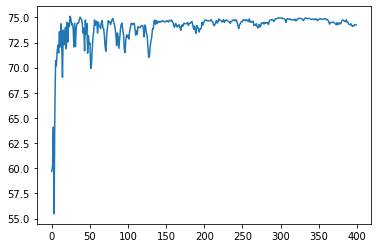

In [40]:

tX_aug_std=augment(tX)
w,loss= train(y,tX_aug_std, logistic_regression_SGD, n_max_iters=400, gamma=best_gamma, lambda_=best_lambda, alpha=best_alpha, plot_accuracy=True)

Polynomial expansion of degree 2 done : adding (250000, 30)
Logarithmic expansion of degree 1 done : adding (250000, 30)
Root expansion of degree 2 done : adding (250000, 30)
Iteration 0/ 400
Accuracy = 59.7204%
Iteration 40/ 400
Accuracy = 74.1584%
Iteration 80/ 400
Accuracy = 73.63199999999999%
Iteration 120/ 400
Accuracy = 73.3128%
Iteration 160/ 400
Accuracy = 74.8172%
Iteration 200/ 400
Accuracy = 74.4688%
Iteration 240/ 400
Accuracy = 74.86120000000001%
Iteration 280/ 400
Accuracy = 74.9944%
Iteration 320/ 400
Accuracy = 75.0552%
Iteration 360/ 400
Accuracy = 74.3564%
Iteration 400/ 400
Accuracy = 74.83840000000001%
Best Accuracy : 75.14359999999999% reached at epoch 87


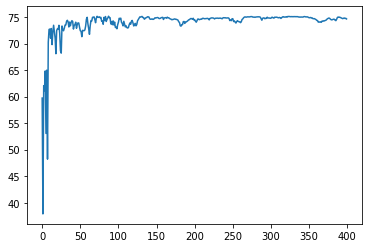

In [36]:
tX_pri_aug_std=augment(tX_pri)
w,loss= train(y_pri,tX_pri_aug_std, logistic_regression_SGD, n_max_iters=400, gamma=best_gamma, lambda_=best_lambda, alpha=best_alpha, plot_accuracy=True)


Polynomial expansion of degree 2 done : adding (250000, 30)
Logarithmic expansion of degree 1 done : adding (250000, 30)
Root expansion of degree 2 done : adding (250000, 30)
Iteration 0/ 400
Accuracy = 59.37519999999999%
Iteration 40/ 400
Accuracy = 73.3072%
Iteration 80/ 400
Accuracy = 73.66080000000001%
Iteration 120/ 400
Accuracy = 73.9616%
Iteration 160/ 400
Accuracy = 75.106%
Iteration 200/ 400
Accuracy = 74.1896%
Iteration 240/ 400
Accuracy = 75.0684%
Iteration 280/ 400
Accuracy = 73.84479999999999%
Iteration 320/ 400
Accuracy = 74.4432%
Iteration 360/ 400
Accuracy = 74.09%
Iteration 400/ 400
Accuracy = 74.56960000000001%
Best Accuracy : 75.242% reached at epoch 68


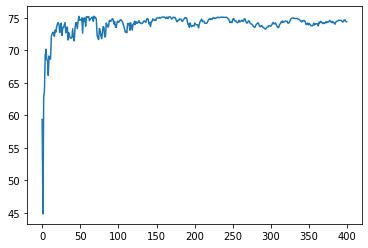

In [38]:
tX_der_aug_std=augment(tX_der)
w,loss= train(y_der,tX_der_aug_std, logistic_regression_SGD, n_max_iters=400, gamma=best_gamma, lambda_=best_lambda, alpha=best_alpha, plot_accuracy=True)


Best Accuracy : 74.964% reached at epoch 349
Best Accuracy : 74.8215% reached at epoch 221
Best Accuracy : 74.8965% reached at epoch 120
Best Accuracy : 75.077% reached at epoch 254
Best Accuracy : 75.1065% reached at epoch 103
Max accuracy this run was 74.9932%
Best Accuracy : 74.9765% reached at epoch 124
Best Accuracy : 75.2605% reached at epoch 180
Best Accuracy : 75.2045% reached at epoch 123
Best Accuracy : 74.703% reached at epoch 313
Best Accuracy : 74.9455% reached at epoch 81
Max accuracy this run was 74.5736%
Best Accuracy : 75.2445% reached at epoch 135
Best Accuracy : 75.116% reached at epoch 194
Best Accuracy : 75.1095% reached at epoch 61
Best Accuracy : 75.131% reached at epoch 58
Best Accuracy : 75.3% reached at epoch 176
Max accuracy this run was 74.92760000000001%


74.65224

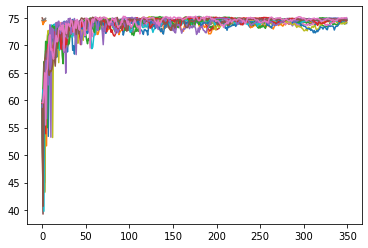

In [39]:
k_fold_CV(y,tX_aug_std, logistic_regression_SGD, k=5, n_max_iters=350, gamma=best_gamma, lambda_=best_lambda, alpha=best_alpha,lr_decay=0.08, logs=False, plot_accuracy=True)
k_fold_CV(y_pri,tX_pri_aug_std, logistic_regression_SGD, k=5, n_max_iters=350, gamma=best_gamma, lambda_=best_lambda, alpha=best_alpha,lr_decay=0.08, logs=False, plot_accuracy=True)
k_fold_CV(y_der,tX_der_aug_std, logistic_regression_SGD, k=5, n_max_iters=350, gamma=best_gamma, lambda_=best_lambda, alpha=best_alpha,lr_decay=0.08, logs=False, plot_accuracy=True)


In [29]:
DATA_TEST_PATH = 'data/test.csv' # TODO: download train data and supply path here 
y_tests, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)


df = pd.DataFrame(np.c_[tX_test,y_tests])
df = pd.DataFrame(np.c_[tX_test,y_tests]).replace(-999., pd.NA).fillna(df.median())
df_np=df.to_numpy(dtype="float128")

y_tests=df_np[:,30]
tX_test=df_np[:,0:30]


tX_aug_test = np.c_[tX_test,simple_polynomial_feature_expansion(tX_test,5)]
tX_aug_test = np.c_[tX_aug_test,simple_logarithmic_feature_expansion(tX_test,5)]
tX_aug_test = np.c_[tX_aug_test,simple_root_feature_expansion(tX_test,5)]
tX_aug_std_test=standardize_data(tX_aug_test)


print(np.sum(y_pred == -y_tests)/y_pred.shape[0])

Polynomial expansion of degree 5 done : adding (568238, 120)
Logarithmic expansion of degree 5 done : adding (568238, 150)
Root expansion of degree 5 done : adding (568238, 120)


NameError: name 'y_pred' is not defined

In [62]:

print(np.sum(y_pred == -y_tests.reshape(y_pred.shape))/y_pred.shape[0])

0.6379809164469817


In [61]:
from datetime import datetime
method = 'SGD-Log_reg'
time = datetime.now().strftime('%Y%m%dH%H%M%S')
OUTPUT_PATH = f'data/submissions/submission_{method}_{time}' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w, tX_aug_std_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

print(y_pred.shape, y_tests.shape)

create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

(568238, 1) (568238,)


In [459]:
def cross_polynomial_feature_expansion(tx):
    tx_expanded = tx
    for i in range(1,tx.shape[1]):
        if i%(tx.shape[1]//10) == 0:
            print("{}th feature expansion, current size {}".format(i, tx_expanded.shape))
        for j in range(i,tx.shape[1]):
            tx_expanded=np.c_[tx_expanded, tx[:,i]*tx[:,j]]
    return tx_expanded

In [465]:
tX_exp= simple_polynomial_feature_expansion(tX_std)

3th feature expansion, current size (250000, 33)
6th feature expansion, current size (250000, 36)
9th feature expansion, current size (250000, 39)
12th feature expansion, current size (250000, 42)
15th feature expansion, current size (250000, 45)
18th feature expansion, current size (250000, 48)
21th feature expansion, current size (250000, 51)
24th feature expansion, current size (250000, 54)
27th feature expansion, current size (250000, 57)
30th feature expansion, current size (250000, 60)


In [500]:
w,loss= train(y,tX_exp, logistic_regression_GD, n_max_iters=300, gamma=0.05, lambda_=0.7, alpha=0.7)

y shape : (250000, 1)
x shape : (250000, 30)
w shape : (61, 1)
Iteration 0/ 300
Accuracy = 34.2676%
Iteration 30/ 300
Accuracy = 66.7508%
Iteration 60/ 300
Accuracy = 66.75999999999999%
Iteration 90/ 300
Accuracy = 66.7632%
Iteration 120/ 300
Accuracy = 66.764%
Iteration 150/ 300
Accuracy = 66.764%
Iteration 180/ 300
Accuracy = 66.7644%
Iteration 210/ 300
Accuracy = 66.764%
Iteration 240/ 300
Accuracy = 66.764%
Iteration 270/ 300
Accuracy = 66.7656%
Iteration 300/ 300
Accuracy = 66.766%


In [458]:
tX_big_exp = cross_polynomial_feature_expansion(tX_std)

1th feature expansion, current size (250000, 31)
2th feature expansion, current size (250000, 61)
3th feature expansion, current size (250000, 90)
4th feature expansion, current size (250000, 118)
5th feature expansion, current size (250000, 145)
6th feature expansion, current size (250000, 171)
7th feature expansion, current size (250000, 196)
8th feature expansion, current size (250000, 220)
9th feature expansion, current size (250000, 243)
10th feature expansion, current size (250000, 265)
11th feature expansion, current size (250000, 286)
12th feature expansion, current size (250000, 306)
13th feature expansion, current size (250000, 325)
14th feature expansion, current size (250000, 343)
15th feature expansion, current size (250000, 360)
16th feature expansion, current size (250000, 376)
17th feature expansion, current size (250000, 391)
18th feature expansion, current size (250000, 405)
19th feature expansion, current size (250000, 418)
20th feature expansion, current size (25000

y shape : (250000, 1)
x shape : (250000, 30)
w shape : (496, 1)
Iteration 0/ 500
Accuracy = 34.6924%
Iteration 50/ 500
Accuracy = 65.7668%
Iteration 100/ 500
Accuracy = 67.28960000000001%
Iteration 150/ 500
Accuracy = 67.828%
Iteration 200/ 500
Accuracy = 67.6848%
Iteration 250/ 500
Accuracy = 66.7752%
Iteration 300/ 500
Accuracy = 67.0164%
Iteration 350/ 500
Accuracy = 67.37480000000001%
Iteration 400/ 500
Accuracy = 67.88680000000001%
Iteration 450/ 500
Accuracy = 68.0724%
Iteration 500/ 500
Accuracy = 66.258%
Best Accuracy : 69.3968% reached at epoch 268


(array([[-4.61719850e+01],
        [ 6.99311903e+00],
        [-4.54040350e+01],
        [ 1.50457596e+00],
        [ 1.76468774e+01],
        [ 1.44940379e+01],
        [ 1.52787610e+01],
        [-1.22093403e+01],
        [ 9.94019936e+00],
        [-3.74936927e+00],
        [ 1.27832932e+01],
        [-2.19998160e+01],
        [ 2.92375094e+01],
        [ 1.41675499e+01],
        [ 2.17808960e+01],
        [-2.77265623e+00],
        [-6.00644047e-01],
        [-3.68595854e+00],
        [ 1.40392683e+00],
        [ 2.64031667e+00],
        [-7.06634907e-01],
        [-6.55409206e-01],
        [ 1.21382205e+01],
        [ 9.57793635e+00],
        [ 3.41301050e+00],
        [ 2.97820624e+00],
        [-1.63639490e+00],
        [ 5.96495280e+00],
        [ 5.63694115e-02],
        [-1.95303614e+00],
        [ 1.09816217e+01],
        [-8.35336942e+01],
        [-1.34977662e+01],
        [-7.05838825e+01],
        [ 1.66976985e+00],
        [ 2.02637735e+00],
        [ 1.17758858e+00],
 

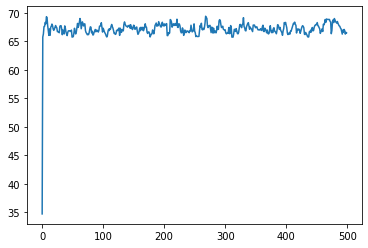

In [543]:
train(y,tX_big_exp, logistic_regression_SGD, n_max_iters=500, gamma=0.2, lambda_=0.7, alpha=0.7, lr_decay=0.1, plot_accuracy=True)

# TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

-170.20857381814852


In [ ]:
print

In [399]:
df.describe()

,1,2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,29,30
count,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000,68114.000000
mean,35.270300,78.496815,111.430393,1.996525,27.356644,281.524727,1.480924,0.637307,45.716667,-0.003367,0.001104,52.433431,-0.003671,0.041897,54.959294,0.006987,334.677667,2.303711,183.374631,-0.063511
std,30.750262,40.728784,76.318688,0.774636,28.266913,130.245426,1.097985,0.924876,29.681876,1.179442,1.818341,28.798872,1.197358,1.815463,42.690672,1.813892,139.867044,0.459863,108.312736,0.997988
min,0.000000,7.330000,0.120000,0.228000,0.004000,110.601000,0.047000,-1.414000,20.000000,-2.496000,-3.141000,26.001000,-2.487000,-3.142000,0.200000,-3.142000,34.323000,2.000000,60.223000,-1.000000
25%,11.320000,57.274250,57.827000,1.397000,4.218000,192.844250,0.762250,0.191000,26.589250,-0.889000,-1.570000,33.280250,-0.908750,-1.518000,27.081000,-1.550000,239.168250,2.000000,109.472000,-1.000000
50%,26.964000,70.930000,94.714000,1.940000,22.542000,246.719500,1.206000,1.071000,36.590500,-0.011000,-0.010000,43.450000,-0.009000,0.077000,44.292000,0.005000,305.170000,2.000000,154.136500,-1.000000
75%,52.202750,88.372000,145.824750,2.574000,39.067750,331.105000,1.854000,1.342000,54.194250,0.879750,1.580000,61.482000,0.904000,1.609000,69.416250,1.573000,396.382500,3.000000,223.595250,1.000000
max,594.287000,789.538000,1053.807000,5.579000,466.525000,1852.462000,19.773000,1.414000,622.862000,2.497000,3.142000,461.896000,2.499000,3.141000,951.363000,3.142000,2003.976000,3.000000,1633.433000,1.000000
